# In the first part of this notebook, we will try to make rankings of wine varieties based on the frequency of terms associated with sweetness, acidity and tannin. In the second part,  we perform an exploratory data analysis of the dataset. 

# Ranking of wine varieties by sweetness, acidity and tannin

In [ ]:
from __future__ import unicode_literals
from textblob import TextBlob
import pandas as pd

In [2]:
wine = pd.read_csv('/Users/luis/Desktop/tfm_folder/winemag-data_first150k.csv.zip',sep=",")
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
wine.columns

Index([u'Unnamed: 0', u'country', u'description', u'designation', u'points',
       u'price', u'province', u'region_1', u'region_2', u'variety', u'winery'],
      dtype='object')

In [4]:
wine = wine.drop('Unnamed: 0',1)

In [5]:
wine = wine.drop_duplicates()

In [6]:
len(wine)

97851

In [7]:
# keeping only varieties with at least 20 reviews
num_reviews = wine.groupby('variety').description.count().to_frame().reset_index()
num_reviews = num_reviews[num_reviews.description > 19]
frequent_varieties = num_reviews.variety.tolist()
wine_f = wine.loc[wine['variety'].isin(frequent_varieties)]

In [8]:
len(wine_f)

95778

Ranking wine varieties by sweetness from descriptions

In [9]:
# we will do this by counting the frequency of words associated with sweetness 
# in the descriptions of each variety (the words will be "sweet","sweetness","sugar","sugary",
#"caramel", and "caramelized")

In [10]:
# first we must clean the text by removing punctuation symbols and setting all words 
# to lowercase letters
import string 

def remove_punctuation(review):
    pepe = review.translate(None, string.punctuation)
    return pepe

# removing punctuation from descriptions
wine['description'] = wine['description'].apply(remove_punctuation)
# converting to lowercase letters
wine['description'] = wine['description'].str.lower()

In [11]:
# a function to locate the maximum element of a list
import numpy as np
def locate_max(list):
    biggest = np.max(list)
    return biggest, [index for index, element in enumerate(list) 
                      if biggest == element]

In [12]:
#example, calculate the frequency of sweetness-words in descriptions of Port wine
porto = wine[wine.variety == "Port"]

sweet_freq = []
for review in porto.description:
    review = TextBlob(review.decode('unicode-escape'))
    num_sweet = review.words.count("sweet")
    num_sweetness = review.words.count("sweetness")
    num_sugar = review.words.count("sugar")
    num_sugary = review.words.count("sugary")
    num_caramel = review.words.count("caramel")
    num_caramelized = review.words.count("caramelized")
    total_sweet = num_sweet+num_sweetness+num_sugar+num_sugary+num_caramel+num_caramelized
    sweet_freq.append(total_sweet)

print(float(sum(sweet_freq))/len(sweet_freq))

/Users/luis/anaconda/lib/python2.7/site-packages/pandas/core/ops.py:739: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  result = lib.scalar_compare(x, y, op)


0.555869872702


In [13]:
locate_max(sweet_freq)

(4, [140])

In [14]:
porto.description.iloc[140]

'this 100 petite sirah is very very sweet when the palate experiences this much concentrated brown sugar and caramel it exults the problem is that sweetness is pretty much all there is youll find blackberry jam and chocolate'

In [15]:
#writing it as a function that assigns a sweetness-score based on a list of descriptions
def sweetness_score(descriptions):
    sweet_freq = []
    for review in descriptions:
        review = TextBlob(review.decode('unicode-escape'))
        num_sweet = review.words.count("sweet")
        num_sweetness = review.words.count("sweetness")
        num_sugar = review.words.count("sugar")
        num_sugary = review.words.count("sugary")
        num_caramel = review.words.count("caramel")
        num_caramelized = review.words.count("caramelized")
        total_sweet = num_sweet+num_sweetness+num_sugar+num_sugary+num_caramel+num_caramelized
        sweet_freq.append(total_sweet)
    return float(sum(sweet_freq))/len(sweet_freq)

In [16]:
sweetness_score(porto.description)

0.5558698727015559

In [17]:
#calculating the frequency of "sweetness-related" words for each variety of wine and saving 
#it in a list tuples of type (wine-variety,frequency)

sweet_list = []
for variety in wine_f.variety.unique():
    df_variety = wine_f[wine_f.variety == variety]
    sweet = sweetness_score(df_variety.description)
    sweet_list.append((variety,sweet))

# sorting from high sweeetness to low sweetness    
sorted_sweet_list = sorted(sweet_list, key=lambda x: -x[1])

In [18]:
# putting the list in dataframe format
df_sweetness = pd.DataFrame(sorted_sweet_list,columns=["variety","sweetness_score"])

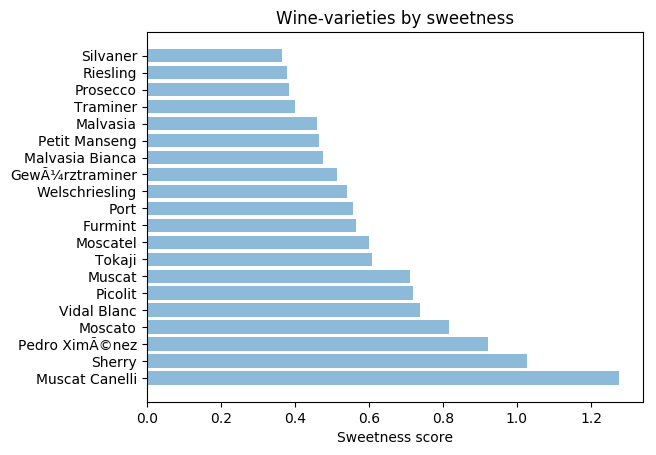

In [19]:
# Barplot of the data
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

varieties = tuple(df_sweetness.variety.tolist())[:20]
varieties = [TextBlob(i.decode('unicode-escape')) for i in varieties]
y_pos = np.arange(len(varieties))
performance = np.array(df_sweetness.sweetness_score)[:20]
error = np.random.rand(len(varieties))

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, varieties)
plt.xlabel('Sweetness score')
plt.title('Wine-varieties by sweetness')
 
plt.show()

Ranking wine varieties by acidity from descriptions

In [20]:
def acidity_score(descriptions):
    acid_freq = []
    for review in descriptions:
        review = TextBlob(review.decode('unicode-escape'))
        num_acid = review.words.count("acid")
        num_acidity = review.words.count("acidity")
        num_acidic = review.words.count("acidic")
        num_sour = review.words.count("sour")
        total_acid = num_acid+num_acidity+num_acidic+num_sour
        acid_freq.append(total_acid)
    return float(sum(acid_freq))/len(acid_freq)

In [21]:
acidity_score(porto.description)

0.38189533239038187

In [22]:
#calculating the frequency of "sweetness-related" words for each variety of wine and saving 
#it in a list tuples of type (wine-variety,frequency)

acid_list = []
for variety in wine_f.variety.unique():
    df_variety = wine_f[wine_f.variety == variety]
    acid = acidity_score(df_variety.description)
    acid_list.append((variety,acid))

# sorting from high sweeetness to low sweetness    
sorted_acid_list = sorted(acid_list, key=lambda x: -x[1])

In [23]:
# putting the list in dataframe format
df_acidity = pd.DataFrame(sorted_acid_list,columns=["variety","acidity_score"])

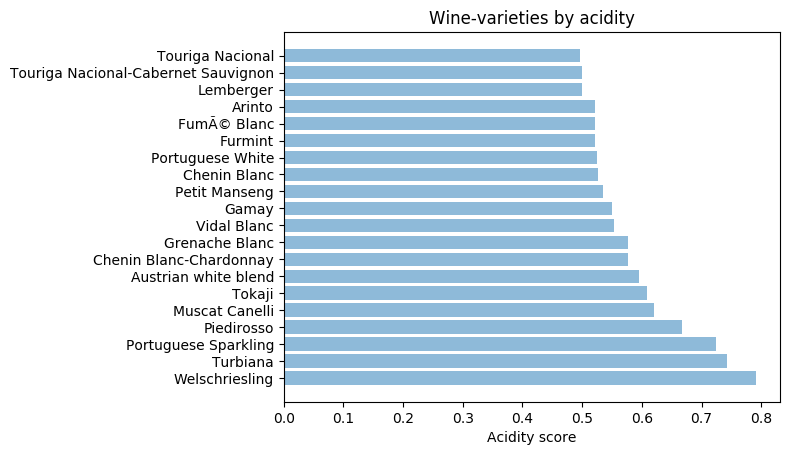

In [24]:
plt.rcdefaults()
fig, ax = plt.subplots()

varieties = tuple(df_acidity.variety.tolist())[:20]
varieties = [TextBlob(i.decode('unicode-escape')) for i in varieties]
y_pos = np.arange(len(varieties))
performance = np.array(df_acidity.acidity_score)[:20]
error = np.random.rand(len(varieties))

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, varieties)
plt.xlabel('Acidity score')
plt.title('Wine-varieties by acidity')
 
plt.show()

In [25]:
df_acidity.head(7)

,variety,acidity_score
0,Welschriesling,0.791667
1,Turbiana,0.742424
2,Portuguese Sparkling,0.724138
3,Piedirosso,0.666667
4,Muscat Canelli,0.620690
5,Tokaji,0.608696
6,Austrian white blend,0.594595


Ranking wine varieties by tannin from descriptions

In [26]:
def tannin_score(descriptions):
    tannin_freq = []
    for review in descriptions:
        review = TextBlob(review.decode('unicode-escape'))
        num_tannin = review.words.count("tannin")
        num_tannic = review.words.count("tannic")
        total_tannin = num_tannin+num_tannic
        tannin_freq.append(total_tannin)
    return float(sum(tannin_freq))/len(tannin_freq)

In [27]:
tannin_score(porto.description)

0.07496463932107496

In [28]:
#calculating the frequency of "sweetness-related" words for each variety of wine and saving 
#it in a list tuples of type (wine-variety,frequency)
tannin_list = []
for variety in wine_f.variety.unique():
    df_variety = wine_f[wine_f.variety == variety]
    tannin = tannin_score(df_variety.description)
    tannin_list.append((variety,tannin))

# sorting from high sweeetness to low sweetness    
sorted_tannin_list = sorted(tannin_list, key=lambda x: -x[1])

In [29]:
sorted_tannin_list[:10]

[('Claret', 0.38095238095238093),
 ('Tinta de Toro', 0.36879432624113473),
 ('Touriga Nacional-Cabernet Sauvignon', 0.35),
 ('Petite Verdot', 0.32432432432432434),
 ('Tannat-Cabernet', 0.2857142857142857),
 ('Tannat', 0.26136363636363635),
 ('Charbono', 0.25),
 ('Tinto del Pais', 0.22807017543859648),
 ('Petite Sirah', 0.20034246575342465),
 ('Tinto Fino', 0.19230769230769232)]

In [30]:
# putting the list in dataframe format
df_tannin = pd.DataFrame(sorted_tannin_list,columns=["variety","tannin_score"])

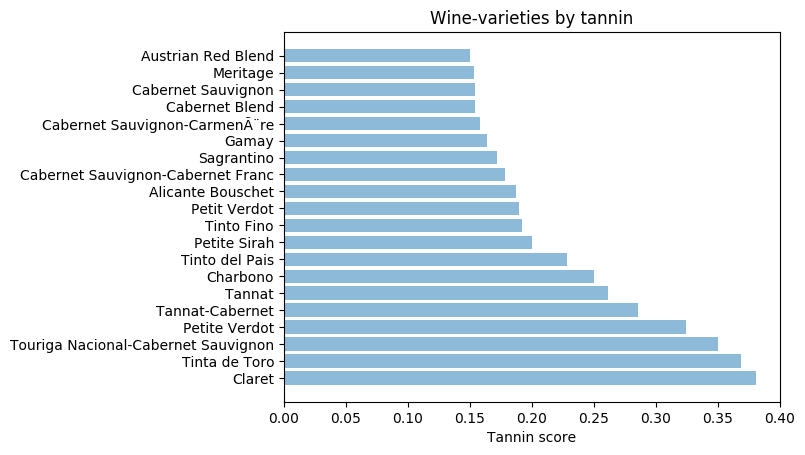

In [31]:
plt.rcdefaults()
fig, ax = plt.subplots()

varieties = tuple(df_tannin.variety.tolist())[:20]
varieties = [TextBlob(i.decode('unicode-escape')) for i in varieties]
y_pos = np.arange(len(varieties))
performance = np.array(df_tannin.tannin_score)[:20]
error = np.random.rand(len(varieties))

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, varieties)
plt.xlabel('Tannin score')
plt.title('Wine-varieties by tannin')
 
plt.show()

# Exploratory data analysis

In [34]:
# Average price and points by country

In [60]:
wine1 = wine_f[["country","points","price"]].groupby("country").mean().reset_index()

In [62]:
wine1.head()

,country,points,price
0,Argentina,86.070633,21.217430
1,Australia,87.937195,31.452136
2,Austria,89.371822,31.073045
3,Brazil,83.428571,20.928571
4,Bulgaria,85.750000,11.354167


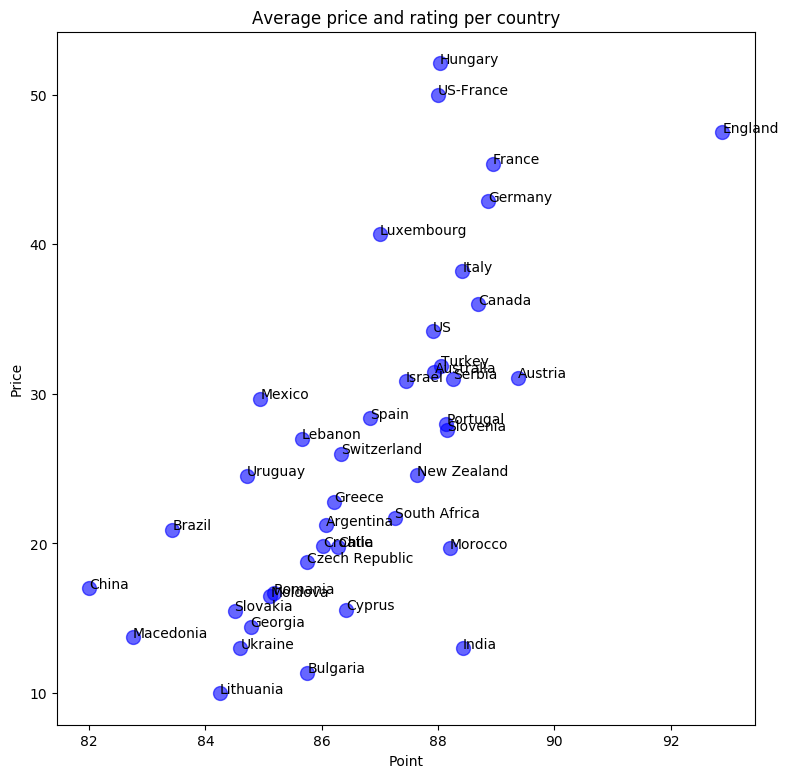

In [199]:
y=wine1["price"]
x=wine1["points"]
n=wine1["country"]
fig, ax = plt.subplots(figsize=(9,9))
ax.scatter(x, y,s =100, color="blue", alpha=0.6)
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
    plt.xlabel("Point")
plt.ylabel("Price")
plt.title("Average price and rating per country")
plt.show()

In [69]:
# number of wine-reviews per country

In [74]:
wine2 = wine_f.country.value_counts().to_frame().reset_index()

In [79]:
wine2 = wine2.rename(columns={'index': 'country', 'country': 'number_of_reviews'})

In [80]:
wine2.head()

,country,number_of_reviews
0,US,40139
1,Italy,14435
2,France,14235
3,Spain,5188
4,Chile,3684


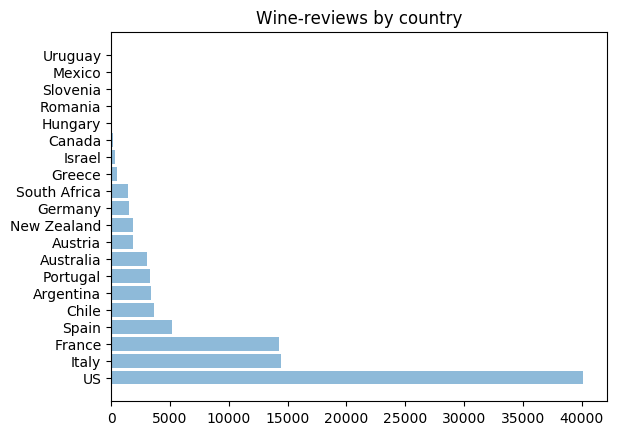

In [87]:
plt.rcdefaults()
fig, ax = plt.subplots()

countries = tuple(wine2.country.tolist())[:20]
countries = [TextBlob(i.decode('unicode-escape')) for i in countries]
y_pos = np.arange(len(countries))
performance = np.array(wine2.number_of_reviews)[:20]
error = np.random.rand(len(countries))


plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, countries)
plt.title('Wine-reviews by country')
 
plt.show()

In [88]:
# number of wineries per country

In [124]:
wine3 = wine_f.groupby("country").winery.unique().to_frame().reset_index()

In [126]:
wine3.head()

,country,winery
0,Argentina,"[Matias Riccitelli, Navarro Correas, Zorzal, V..."
1,Australia,"[Moorooduc, Riposte, Giant Steps, D'Arenberg, ..."
2,Austria,"[Johanneshof Reinisch, Muhr-Van der Niepoort, ..."
3,Brazil,"[Lidio Carraro, Vinícola Miolo, Cordelier, Vil..."
4,Bulgaria,"[Vini, Castra Rubra, K Cellars, Chateau Burgoz..."


In [128]:
wine3["number_of_wineries"] = wine3.winery.apply(len)

In [131]:
wine3 = wine3.sort_values(by="number_of_wineries",ascending=False)

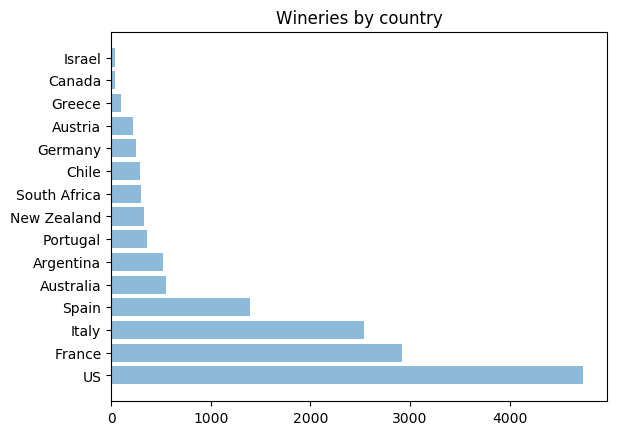

In [134]:
plt.rcdefaults()
fig, ax = plt.subplots()

countries = tuple(wine3.country.tolist())[:15]
countries = [TextBlob(i.decode('unicode-escape')) for i in countries]
y_pos = np.arange(len(countries))
performance = np.array(wine3.number_of_wineries)[:15]
error = np.random.rand(len(countries))


plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, countries)
plt.title('Wineries by country')
 
plt.show()

In [135]:
# number of varieties by country

In [149]:
wine4 = wine_f.groupby("country").variety.unique().to_frame().reset_index()

In [150]:
wine4["number_of_varieties"] = wine4.variety.apply(len)

In [151]:
wine4 = wine4.sort_values(by="number_of_varieties",ascending=False)

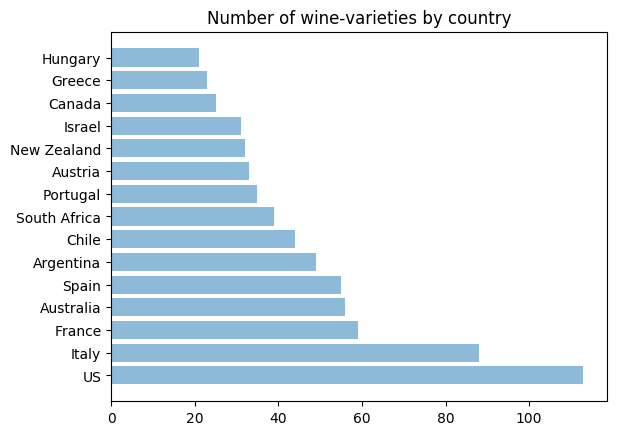

In [152]:
plt.rcdefaults()
fig, ax = plt.subplots()

countries = tuple(wine4.country.tolist())[:15]
countries = [TextBlob(i.decode('unicode-escape')) for i in countries]
y_pos = np.arange(len(countries))
performance = np.array(wine4.number_of_varieties)[:15]
error = np.random.rand(len(countries))


plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, countries)
plt.title('Number of wine-varieties by country')
 
plt.show()

In [191]:
wine5 = wine.groupby("variety").variety.count().sort_values(ascending=False).to_frame()

In [192]:
wine5 = wine5.rename(columns={'variety': 'number_of_reviews'})

In [194]:
wine5.head()

,number_of_reviews
variety,
Pinot Noir,9283
Chardonnay,9163
Cabernet Sauvignon,8272
Red Blend,6485
Bordeaux-style Red Blend,5176


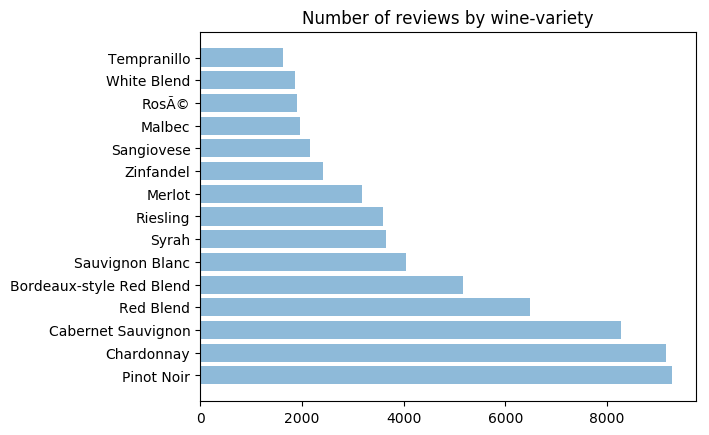

In [198]:
plt.rcdefaults()
fig, ax = plt.subplots()

varieties = tuple(wine5.index.tolist())[:15]
varieties = [TextBlob(i.decode('unicode-escape')) for i in varieties]
y_pos = np.arange(len(varieties))
performance = np.array(wine5.number_of_reviews)[:15]
error = np.random.rand(len(varieties))


plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, varieties)
plt.title('Number of reviews by wine-variety')
 
plt.show()